<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">UNLABELED DATA - CLUSTERING ANALYSIS</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 10:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Grouping objects with k-means](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. k-means clustering using scikit-learn](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Silhouette analysis](#1b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Hierarchical clustering](#2)</p>
        <p style="margin: 0 0 0 4rem">[2a. The merging algorithm](#2a)</p>
        <p style="margin: 0 0 0 4rem">[2b. Building dendrograms with SciPy](#2b)</p>
        <p style="margin: 0 0 0 4rem">[2c. Attaching a heatmap to a dendrogram](#2c)</p>
        <p style="margin: 0 0 0 4rem">[2d. Agglomerative clustering with scikit-learn](#2d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Density-based clustering with DBSCAN](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. The DBSCAN algorithm](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Running DBSCAN on an example](#3b)</p></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt

# The datasets we will use :
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

# Beautify code results using colors
from colorama import Fore, Back, Style
# define some strings for cleaner codes
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT

# Beautify DataFrames using colors
def beautify(df):
    # df.style creates a Styler object from the (pandas) DataFrame 'df', which allows styling to be applied to 
    # the dataframe's representation; then 'set_table_styles' applies css styling (eg 'text-align: center') to
    # the table header cells (<th>) and data cells (<td>) of the DataFrame
    # The Styler object resets the precision of floats to 6 decimal places, whatever their original format; only
    # the display is affected, though, not the original data; here, the floats are float64 numbers and correspond
    # to random numbers in [0, 10[, so there is no need to reformat them
    return df.style.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('color', 'blue')]}, 
        {'selector': 'td', 'props': [('text-align', 'center'), ('color', 'magenta'), ('font-weight', 'bold')]}])

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In this chapter, we will explore <font color='darkpink'>cluster analysis</font>, a category of <font color='#cc33ff'>unsupervised learning techniques</font> that allows us to discover hidden structures in data whose <font color='#cc33ff'>target values</font> or <font color='#cc33ff'>labels</font> are not known. The goal of <font color='#cc33ff'>clustering</font> is to find a natural grouping in data so that items in the same <font color='#cc33ff'>cluster</font> are more similar to each other than to those from other <font color='#cc33ff'>clusters</font>.<br>
    Examples of applications of <font color='#cc33ff'>clustering</font> include the grouping of documents, music, and movies by topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines.<br>$\quad$
        Given its exploratory nature, <font color='#cc33ff'>clustering</font> is an exciting subject, and, in this part, we will learn about
the following concepts :<ul style="margin-top: 5px">
    <li>Find <font color='darkpink'>centers of similarity</font> using the popular <font color='darkpink'>k-means algorithm</font> (ch 1)</li>
    <li>Take a bottom-up approach to building <font color='darkpink'>hierarchical clustering trees</font> (ch 2)</li>
    <li>Identify arbitrary shapes of objects using a <font color='darkpink'>density-based clustering</font> approach (ch 3)</li></ul>

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. GROUPING OBJECTS WITH k-MEANS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. k-means clustering using scikit-learn</font><a id="1a"></a></p>$\quad$
        The <font color='darkpink'>k-means algorithm</font> belongs to the category of <font color='darkpink'>prototype-based clustering</font>. Each <font color='#cc33ff'>cluster</font> is represented by a <font color='#cc33ff'>prototype</font>, which often is either its <font color='darkpink'>centroid</font> (average) in the case of continuous features, or the <font color='darkpink'>medoid</font> (the point that minimizes the total distance to all other points in the <font color='#cc33ff'>cluster</font>) in the case of categorical features.<br>$\quad$
        The <font color='#cc33ff'>k-means algorithm</font> is easy to implement (see below), and it is also computationally very efficient compared to other <font color='#cc33ff'>clustering algorithms</font>. The main drawback of this <font color='#cc33ff'>clustering algorithm</font> is that we need to specify the right <font color='#cc33ff'>number of clusters</font>, <font color='#1aabff'>$k$</font>. An inappropriate choice for <font color='#1aabff'>$k$</font> can result in poor <font color='#cc33ff'>clustering performance</font>.<br>
    Later in this chapter, we will discuss the <font color='darkpink'>elbow method</font> and <font color='darkpink'>silhouette plots</font>, which are useful techniques to evaluate the <font color='#cc33ff'>quality of a clustering</font>, and help us determine the <font color='#cc33ff'>optimal number of clusters</font>.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='magenta'>Although <font color='#cc33ff'>k-means clustering</font> can be applied to data in higher dimensions, we will walk through some examples using a simple two-dimensional dataset, for the purpose of visualization.</font><br>$\quad$
        In order to generate a few <font color='#cc33ff'>clusters</font> of <font color='#cc33ff'>data points</font>, we use <font color='#cc33ff'>scikit-learn</font>'s function <font color='#cc33ff'>make_blobs(n_samples=100, n_features=2, centers=None, cluster_std=1.0, shuffle=True, random_state=None, return_centers=False)</font> from its <font color='#cc33ff'>datasets</font> module. It generates <font color='#cc33ff'>clusters</font> of points randomly chosen according to Gaussian distributions (one per cluster), each centered at a <font color='#cc33ff'>cluster center</font> with <font color='#cc33ff'>isotropic variance</font> (ie a variance which is the same in all directions, which favors spherical clusters). I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>n_samples=100</font> : either the total number of samples, <font color='#1aabff'>$m$</font>, which will be equally distributed among clusters, or a 1D array of length the number <font color='#1aabff'>$c$</font> of <font color='#cc33ff'>clusters</font> providing the number of samples per cluster</li>
    <li><font color='#cc33ff'>n_features=2</font> : the number <font color='#1aabff'>$n$</font> of features for each point</li>
    <li><font color='#cc33ff'>centers=None</font> : if it is an integer, it specifies the number of centers (hence the value of <font color='#1aabff'>$c$</font>); we can specify the <font color='#cc33ff'>center locations</font> by instead assigning a 2D array of shape <font color='#cc33ff'>(<font color='#1aabff'>$c$</font>, <font color='#1aabff'>$n$</font>)</font>. If <font color='#cc33ff'>n_samples</font> is an integer and <font color='#cc33ff'>centers=</font><font color='#1aabff'>None</font> (or <font color='#cc33ff'>centers=</font><font color='#1aabff'>3</font>), 3 centers are generated; if <font color='#cc33ff'>n_samples</font> is a 1D array, then <font color='#cc33ff'>centers</font> must be either <font color='#1aabff'>None</font> or a 2D array of shape <font color='#cc33ff'>(<font color='#1aabff'>$c$</font>, <font color='#1aabff'>$n$</font>)</font></li>
    <li><font color='#cc33ff'>cluster_std=1.0</font> : a float or a 1D array of floats of length <font color='#1aabff'>$c$</font> specifying the standard deviation(s) of the clusters</li>
    <li><font color='#cc33ff'>shuffle=True</font> : specifies whether or not the points should be shuffled</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed of the random number generator (ensuring reproducibility)</li>
    <li><font color='#cc33ff'>return_centers=False</font> : specifies whether or not the <font color='#cc33ff'>cluster centers</font> should be returned</li></ul><div style="margin-top: 20px"></div>$\quad$
        The function returns <font color='#cc33ff'>X</font> - the array of shape <font color='#cc33ff'>(<font color='#1aabff'>$m$</font>, <font color='#1aabff'>$n$</font>)</font> of the <font color='#cc33ff'>generated data points</font> -; <font color='#cc33ff'>y</font> - the 1D array of length <font color='#1aabff'>$m$</font> of the <font color='#cc33ff'>integers labeling the clusters</font>, and, if <font color='#cc33ff'>return_centers=True</font>, <font color='#cc33ff'>centers</font> - the array of shape <font color='#cc33ff'>(<font color='#1aabff'>$c$</font>, <font color='#1aabff'>$n$</font>)</font> holding the <font color='#cc33ff'>cluster centers</font>. Note that <font color='#cc33ff'>centers</font> is overloaded : when an integer, it is the number of <font color='#cc33ff'>clusters</font>; when a matrix, it holds the locations of the centers.<div style="margin-top: 20px"></div>$\quad$
        Let's now create a dataset of 150 randomly generated points that are roughly grouped into three regions (<font color='#cc33ff'>clusters</font>) of higher point density :

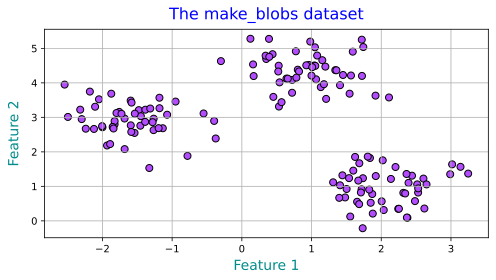

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5, shuffle=True, random_state=0)

plt.figure(figsize=(7, 4))
plt.title("The make_blobs dataset", fontsize=16, color='blue', pad=10)
plt.scatter(X[:, 0], X[:, 1], marker='o', edgecolor='black', s=50, color=cmap(0.7))
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=10, fontsize=14, color='darkcyan')
plt.grid()
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>k-means algorithm</font> consists of the following 4 steps :<font color='darkcyan'><ol>
    <li>Randomly pick <font color='#1aabff'>$k$</font> <font color='#cc33ff'>centroids</font> <font color='#1aabff'>$\;\mu^{(j)},\, j=1,\cdots,k\;$</font> from the <font color='#cc33ff'>example points</font>; they will be our <font color='#cc33ff'>initial cluster centers</font></li>
    <li>Assign each <font color='#cc33ff'>example</font> to the nearest <font color='#cc33ff'>centroid</font>, according to the Euclidean distance</li>
    <li>Update each <font color='#cc33ff'>centroid</font> to the mean of the points currently assigned to it</li>
    <li>Repeat steps 2 and 3 until the <font color='#cc33ff'>cluster assignments</font> do not change, or a user-defined <font color='#cc33ff'>maximum number of iterations</font> or <font color='darkpink'>tolerance</font> (see below) is reached</li></ol></font><div style="margin-top: 20px"></div>$\quad$
        The goal of the <font color='#cc33ff'>k-means algorithm</font> is to find the <font color='#cc33ff'>centroids</font> <font color='#1aabff'>$\;\mu^{(j)},\, j=1,\cdots,k\;$</font> which minimize the <font color='darkpink'>sum of squared errors</font> (<font color='darkpink'>$SSE$</font>), which is sometimes also called the <font color='darkpink'>cluster inertia</font> :<div style="margin-top: 10px"></div><font color = darkpink>
        $$SSE \;\,=\;\, \sum_{i=1}^n \; \sum_{j=1}^k \; 1_{x^{(i)} \in C_j} \, \|x^{(i)}-\mu^{(j)}\|_2^2 \qquad\quad (1)$$</font><div style="margin-top: 10px"></div>
    where the <font color='#1aabff'>$\;x^{(i)}, \, i=1,\cdots,n\;$</font> are the <font color='#cc33ff'>example points</font>, <font color='#1aabff'>$\, 1_{x^{(i)} \in C_j} \,$</font> is equal to $1$ if <font color='#1aabff'>$\, x^{(i)} \,$</font> is in the <font color='#cc33ff'>cluster</font> <font color='#1aabff'>$\, C_j \,$</font> of <font color='#cc33ff'>centroid</font> <font color='#1aabff'>$\mu_j\,$</font> and $0$ otherwise, and <font color='#1aabff'>$\,\|.\|_2\,$</font> is the Euclidean norm.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>k-means algorithm</font> is implemented in the <font color='#cc33ff'>cluster</font> module of <font color='#cc33ff'>scikit-learn</font>. We use the class <font color='#cc33ff'>KMeans(n_clusters=8, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None)</font>, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>n_clusters=8</font> : the number <font color='#1aabff'>$c$</font> of clusters to form as well as the number of centroids to generate</li>
    <li><font color='#cc33ff'>init='k-means++'</font> : the method used to initialize the <font color='#cc33ff'>centroids</font>. <font color='#cc33ff'>init=</font><font color='#1aabff'>'random'</font> randomly chooses <font color='#1aabff'>$c$</font> <font color='#cc33ff'>initial centroids</font> among the examples of the dataset <font color='#1aabff'>X</font> passed to the <font color='#cc33ff'>KMeans</font> instance (via <font color='#cc33ff'>.fit(<font color='#1aabff'>X</font>)</font>, see below). By contrast, the default <font color='#cc33ff'>init=</font><font color='#1aabff'>'k-means++'</font> uses <font color='#cc33ff'>scikit-learn</font>'s <font color = darkpink>greedy k-means++ algorithm</font> : it first randomly chooses one <font color='#cc33ff'>initial centroid</font> among the examples of <font color='#1aabff'>X</font>, and then adds the missing <font color='#cc33ff'>initial centroids</font> recursively; at each step, it assigns to each example the weight equal to the smallest squared Euclidean distance from the example to the currently existing <font color='#cc33ff'>initial centroids</font>; then, it randomly selects 5 candidates among the examples, following the weighted probability (so the more distant an example is from the current <font color='#cc33ff'>initial centroids</font>, the more likely it is to be picked up); and, finally, it adds the candidate which yields the smallest <font color='#cc33ff'>$SSE\,$</font> to the list of <font color='#cc33ff'>initial centroids</font>; the algorithm stops when the number of <font color='#cc33ff'>initial centroids</font> is equal to <font color='#1aabff'>$c$</font></li>
    <li><font color='#cc33ff'>n_init='auto'</font> : the number of times the <font color='#cc33ff'>k-means algorithm</font> is run before selecting the <font color='#cc33ff'>centroids</font>. For any integer <font color='#1aabff'>$p$</font>, if <font color='#cc33ff'>n_init=</font><font color='#1aabff'>$p$</font>, then the <font color='#cc33ff'>k-means algorithm</font> is run <font color='#1aabff'>$p$</font> times, whatever the value of <font color='#cc33ff'>init</font>, each time with a different set of <font color='#cc33ff'>initial centroids</font>, and the <font color='#cc33ff'>KMeans</font> instance selects the <font color='#cc33ff'>final centroids</font> which yield the smallest <font color='#cc33ff'>$SSE\,$</font>. By contrast, with the default <font color='#cc33ff'>n_init=</font><font color='#1aabff'>'auto'</font>, the number of times the <font color='#cc33ff'>k-means algorithm</font> is run depends on the value of <font color='#cc33ff'>init</font> : 1 if <font color='#cc33ff'>init=</font><font color='#1aabff'>'k-means++'</font>, and 10 if <font color='#cc33ff'>init=</font><font color='#1aabff'>'random'</font></li>
    <li><font color='#cc33ff'>max_iter=300</font> : the maximum number of iterations of the <font color='#cc33ff'>k-means algorithm</font>, for a single run</li>
    <li><font color='#cc33ff'>tol=0.0001</font> : the <font color='#cc33ff'>tolerance</font>; the algorithm is stopped if the <font color='purple'>Frobenius norm</font> of the difference between the <font color='#1aabff'>$\, c \!\times\! n \,$</font> matrix holding the <font color='#cc33ff'>centroid locations</font> computed at one step and the same matrix at the previous iteration is less than <font color='#cc33ff'>tol</font> (the <font color='#cc33ff'>Frobenius norm</font> of a matrix <font color='#1aabff'>$A$</font> being the square root of the sum of the squares of all the elements of <font color='#1aabff'>$A$</font> : <font color='purple'>$\|A\|_F^2 = \sum_{i=1}^{n} \sum_{j=1}^{m} A_{ij}^2$</font>)</li>
    <li><font color='#cc33ff'>verbose=0</font> : controls the messages that <font color='#cc33ff'>scikit-learn</font> prints during the training session (mainly used in long runs). By default, it prints nothing. When <font color='#cc33ff'>verbose=</font><font color='#1aabff'>$p$</font>, with any integer <font color='#1aabff'>$\, p\!\geq\!1 \,$</font>, it prints "Initialization complete", followed by one line per iteration showing the iteration number and the corresponding inertia (i.e. <font color='#cc33ff'>$SSE\,$</font>)</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed of the random number generator</li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following methods and attributes available through <font color='#cc33ff'>KMeans</font> :<ul>
    <li><font color='#cc33ff'>.fit(X)</font> : computes the <font color='#cc33ff'>k-means clusters</font> to split the <font color='#1aabff'>$m$</font> instances of our training matrix <font color='#1aabff'>$X$</font></li>
    <li><font color='#cc33ff'>.predict(X)</font> : once the <font color='#cc33ff'>KMeans</font> instance has been trained, we have the <font color='#cc33ff'>centroids</font>, and we can therefore assign any new instance to the <font color='#cc33ff'>cluster</font> containing the nearest <font color='#cc33ff'>centroid</font>; the <font color='#cc33ff'>clusters</font> are referenced by an index, starting at $0$. Here <font color='#cc33ff'>X</font> often is the test or validation matrix</li>
    <li><font color='#cc33ff'>.fit_predict(X)</font> : equivalent to <font color='#cc33ff'>.fit(X)</font> followed by <font color='#cc33ff'>.predict(X)</font></li>
    <li><font color='#cc33ff'>cluster_centers_</font> : returns the 2D array of shape <font color='#cc33ff'>(<font color='#1aabff'>$c$</font>, <font color='#1aabff'>$n$</font>)</font> containing the coordinates of the <font color='#cc33ff'>centroids</font></li>
    <li><font color='#cc33ff'>labels_</font> : returns the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the index of the <font color='#cc33ff'>cluster</font> containing <font color='#1aabff'>$x^{(i)}$</font></li>
    <li><font color='#cc33ff'>inertia_</font> : returns the <font color='#cc33ff'>$SSE\,$</font> (ie <font color='#cc33ff'>inertia</font>)</li>
    <li><font color='#cc33ff'>n_iter_</font> : returns the number of iterations run</li></ul><div style="margin-top: 20px"></div>$\quad$
        Let's try the <font color='#cc33ff'>KMeans</font> class on our example points from cell 2; first with <font color='#cc33ff'>init='random'</font>, then with <font color='#cc33ff'>init='k-means++'</font>. The second option is "strongly recommended in practice" and will be used in the remainder of this section :

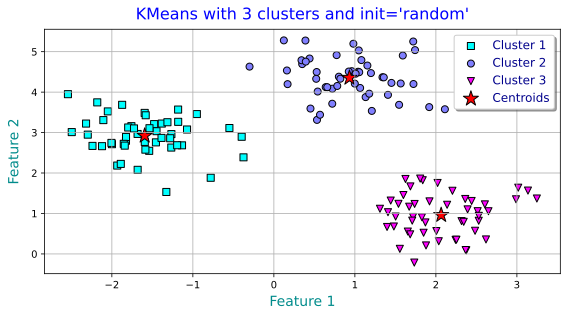

In [3]:
# I get a warning from the joblib library, which is used internally by scikit-learn for parallel processing, when
# I run this code from my potato laptop; but it runs without warning on a better laptop I've tried. The warning
# says that the loky backend is having trouble detecting the number of physical CPU cores on my laptop; it found
# 0 physical cores, and therefore it defaults to using the logical core count. To silence this warning I followed
# ChatGPT's advice : my laptop has 4 physical cores, so I pass the info. If I run this cell twice, then the second
# time the warning does not appear. I suppose if you have a good computer, you can safely remove these two lines :
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

from sklearn.cluster import KMeans
# Fitting the KMeans algorithm
# "n_init='auto'" is equivalent here to "n_init=10" because "init='random'"; the k-means algorithm will be run 10
# times, and the best set of 3 centroids (the one that minimizes the SSE) will be chosen
km = KMeans(n_clusters=3, init='random', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

# Plotting the clusters
plt.figure(figsize=(8, 4.5))
plt.title("KMeans with 3 clusters and init='random'", fontsize=16, color='blue', pad=10)
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label="Cluster 1")
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label="Cluster 2")
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, marker='v', edgecolor='black', color=cmap(0.999),
            label="Cluster 3")
# Plotting the centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black',
            label="Centroids")
# Adding labels and legend
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=10, fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()
plt.tight_layout()
plt.show()

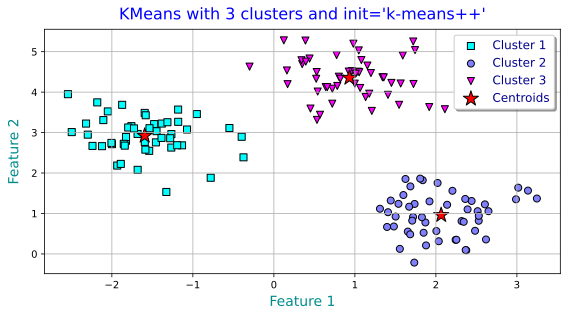

In [4]:
# Fitting the KMeans algorithm
# "n_init='auto'" is equivalent here to "n_init=1" because init is 'k-means++'
km = KMeans(n_clusters=3, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

# Plotting the clusters
plt.figure(figsize=(8, 4.5))
plt.title("KMeans with 3 clusters and init='k-means++'", fontsize=16, color='blue', pad=10)
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label="Cluster 1")
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label="Cluster 2")
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, marker='v', edgecolor='black', color=cmap(0.999),
            label="Cluster 3")
# Plotting the centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red',
            edgecolor='black', label="Centroids")
# Adding labels and legend
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=10, fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()    # displays the grid for better readability
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, the <font color='#cc33ff'>k-means algorithm</font> works well on this toy dataset : fast and neat. But we knew the number of <font color='#cc33ff'>clusters</font>, <font color='#1aabff'>$k$</font>. A drawback of the <font color='#cc33ff'>k-means algorithm</font> is that <font color='#1aabff'>$k$</font> must be specified a priori. This number is rarely obvious in real-world applications, especially if we are working with a higher-dimensional dataset that cannot be visualized.<br>$\quad$
        One common method to select an appropriate number of <font color='#cc33ff'>clusters</font> is to plot the <font color='#cc33ff'>$SSE\,$</font> (also called <font color='#cc33ff'>inertia</font>) against the number <font color='#1aabff'>$k$</font> of clusters. As <font color='#1aabff'>$k$</font> increases, the <font color='#cc33ff'>$SSE\,$</font> decreases, because the data points are assigned to <font color='#cc33ff'>closer centroids</font>. Initially, the decrease is steep, unless the data points are already grouped in a <font color='#cc33ff'>single cluster</font>; and since the <font color='#cc33ff'>$SSE\,$</font> is a positive number, the decrease will become near horizontal for <font color='#1aabff'>$k$</font> large enough. The <font color='darkpink'>elbow method</font> consists in choosing the value of <font color='#1aabff'>$k$</font> at which the rate of decrease of the <font color='#cc33ff'>$SSE,$</font> sharply slows down, often visible as an "elbow" in the curve. One advantage of this method is that it helps select an appropriate number of <font color='#cc33ff'>clusters</font> regardless of the feature space dimension.<br>$\quad$
        Let's apply it on our example; it seems the right number of clusters is <font color='#1aabff'>$\, k=3 \,$</font> :

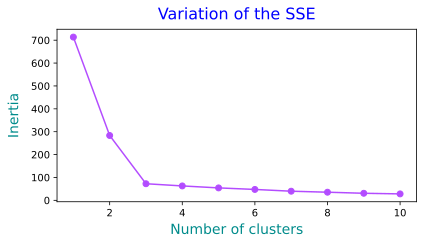

In [5]:
inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 3.5))
plt.title("Variation of the SSE", fontsize=16, color='blue', pad=10)
plt.plot(range(1,11), inertias, marker='o', color=cmap(0.7))
plt.xlabel("Number of clusters", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Inertia", labelpad=10, fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        If we use only $2$ <font color='#cc33ff'>clusters</font>, then we obtain a <font color='#cc33ff'>clustering</font> that is not as good, with one <font color='#cc33ff'>centroid</font> located between two of the three spherical groupings of the input data. Although the <font color='#cc33ff'>clustering</font> does not look completely terrible, it is suboptimal :

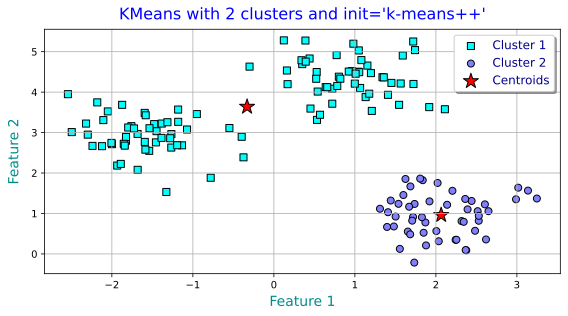

In [6]:
km_2 = KMeans(n_clusters=2, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km_2 = km_2.fit_predict(X)

plt.figure(figsize=(8, 4.5))
plt.title("KMeans with 2 clusters and init='k-means++'", fontsize=16, color='blue', pad=10)
plt.scatter(X[y_km_2 == 0, 0], X[y_km_2 == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label="Cluster 1")
plt.scatter(X[y_km_2 == 1, 0], X[y_km_2 == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label="Cluster 2")
plt.scatter(km_2.cluster_centers_[:, 0], km_2.cluster_centers_[:, 1], s=250, marker='*', c='red',
            edgecolor='black', label="Centroids")
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=10, fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()
plt.tight_layout()
plt.show()

<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Silhouette analysis</font><a id="1b"></a></p>$\quad$
        Besides <font color='#cc33ff'>$SSE\,$</font>, another metric to evaluate the quality of a <font color='#cc33ff'>clustering</font> is <font color='darkpink'>silhouette analysis</font>, which can also be applied to <font color='#cc33ff'>clustering algorithms</font> other than k-means.<br>$\quad$
        While the <font color='#cc33ff'>$SSE\,$</font> computes the sum of the squared distances between our instances and the centroids they have been assigned to, <font color='#cc33ff'>silhouette analysis</font> focuses on the quality of the <font color='#cc33ff'>clusters</font> themselves : how tight they are, compared to how well they are separated from the other <font color='#cc33ff'>clusters</font>.<br>$\quad$
        It computes, for each instance <font color='#1aabff'>$x^{(i)}$</font>, its <font color='darkpink'>cluster cohesion</font> <font color='#1aabff'>$a^{(i)}$</font>, its <font color='darkpink'>cluster separation</font> <font color='#1aabff'>$b^{(i)}$</font>, and its <font color='darkpink'>silhouette coefficient</font> <font color='#1aabff'>$s^{(i)}$</font>. <font color='#1aabff'>$a^{(i)}$</font> is the average distance between <font color='#1aabff'>$x^{(i)}$</font> and all other points in the same <font color='#cc33ff'>cluster</font>, say <font color='#1aabff'>$C_j$</font> :<div style="margin-top: 10px"></div><font color = darkpink>
        $$a^{(i)} \;\,=\;\, \frac{1}{|C_j|-1} \;\sum_{x^{(l)} \in C_j} \; \lVert x^{(i)} - x^{(l)} \rVert_2 \qquad\quad (2)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$\, |C_j| \,$</font> is the cardinality of <font color='#1aabff'>$C_j$</font>, and <font color='#1aabff'>$\|.\|$_2</font> is the Euclidean norm. By contrast, <font color='#1aabff'>$b^{(i)}$</font> is the average distance between <font color='#1aabff'>$x^{(i)}$</font> and all instances in the nearest <font color='#cc33ff'>cluster</font>, say <font color='#1aabff'>$C_{j'}$</font> :<div style="margin-top: 10px"></div><font color = darkpink>
        $$b^{(i)} \;\,=\;\, \frac{1}{|C_{j'}|-1} \;\sum_{x^{(l')} \in C_{j'}} \; \lVert x^{(i)} - x^{(l')} \rVert_2 \qquad\quad (3)$$</font><div style="margin-top: 10px"></div>
    Then <font color='#1aabff'>$s^{(i)}$</font> is defined by<div style="margin-top: 10px"></div><font color = darkpink>
        $$s^{(i)} \;=\; \frac{b^{(i)} - a^{(i)}}{\text{max}(b^{(i)}, a^{(i)})} \;\in \big[-\!1\,;\,+1\big] \qquad\quad (4)$$</font><div style="margin-top: 10px"></div>$\quad$
        The farther <font color='#1aabff'>$x^{(i)}$</font> is from the examples of its closest cluster, the larger <font color='#1aabff'>$b^{(i)}$</font> will be; and the closer <font color='#1aabff'>$x^{(i)}$</font> is to the examples of its own cluster, the smaller <font color='#1aabff'>$a^{(i)}$</font> will be. In total, it is ideal if <font color='#1aabff'>$\,b^{(i)} \gg a^{(i)}\,$</font> - meaning that $x^{(i)}$ is well separated from the other clusters -, in which case its silhouette coefficient will be close to $1$. On the contrary, a silhouette coefficient close to $0$ indicates overlapping clusters. We get an idea of the quality of the <font color='#cc33ff'>clusters</font> (cohesion and separation) by computing the <font color='darkpink'>(average) silhouette score</font>, which is the mean of the <font color='#cc33ff'>silhouette coefficients</font>.<br>$\quad$
        We will now represent the <font color='#cc33ff'>silhouette coefficients</font> in a <font color='darkpink'>silhouette plot</font>.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        First, we compute the <font color='#cc33ff'>silhouette coefficients</font> by using the <font color='#cc33ff'>silhouette_samples(X, labels)</font> function from the <font color='#cc33ff'>metrics</font> module of <font color='#cc33ff'>scikit-learn</font>, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>X</font> : our dataset matrix <font color='#1aabff'>$X$</font>, of shape <font color='#cc33ff'>(<font color='#1aabff'>$m$</font>, <font color='#1aabff'>$n$</font>)</font>, where <font color='#1aabff'>$m$</font> is the number of examples, and <font color='#1aabff'>$n$</font> is the number of features</li>
    <li><font color='#cc33ff'>labels</font> : the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the index of the <font color='#cc33ff'>cluster</font> predicted to contain <font color='#1aabff'>$x^{(i)}$</font>; it is usually obtained from a clustering algorithm’s prediction, eg from <font color='#cc33ff'>KMeans.labels_</font> or <font color='#cc33ff'>KMeans.fit_predict(X)</font> (see previous subchapter)</li></ul><div style="margin-top: 20px"></div>$\quad$
        <font color='#cc33ff'>silhouette_samples</font> returns <font color='#cc33ff'>silhouette</font>, the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the <font color='#cc33ff'>silhouette coefficient</font> of <font color='#1aabff'>$x^{(i)}$</font>.<br>$\quad$
        Using <font color='#cc33ff'>silhouette_samples</font>, let's create a plot of the silhouette coefficients for our example of a k-means clustering with $k = 3$; and then compare it with the silhouette plot that we would have obtained if we had used only $2$ clusters :

	The average silhouette score is : 0.7143417887288687 



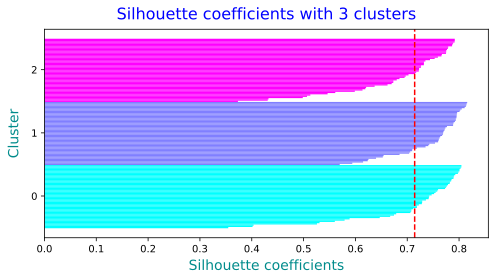

In [7]:
from sklearn.metrics import silhouette_samples

# Use scikit-learn's KMeans class (see previous subchapter) in order to split X into 3 clusters
km_3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
# y_km_3 is the 1D array whose i-th component is the index of the cluster containing the i-th instance of X
y_km_3 = km_3.fit_predict(X)

# Compute the silhouette coefficients for each example
silhouette_vals = silhouette_samples(X, y_km_3)
# Compute and print the average silhouette score across all samples
silhouette_avg = np.mean(silhouette_vals)
print(BB + "\tThe average silhouette score is :" + MB, silhouette_avg, "\n")

# Use our favorite colormap (see cell 1)
cluster_colors = [cmap(0), cmap(0.5), cmap(0.999)]

# Plot the silhouette coefficients for each cluster
plt.figure(figsize=(7, 4))
plt.title("Silhouette coefficients with 3 clusters", fontsize=16, color='blue', pad=10)
# Initialize the lower and upper bounds for the y-axis
y_ax_lower, y_ax_upper = 0, 0
# Initialize a list to store the y-ticks positions
yticks = []
# 'np.unique(y_km_3)' is the list of unique values found in the array 'y_km_3', sorted in ascending order
# 'i' is the list index, and 'c' is the cluster label (which is equal to 'i' here)
for i, c in enumerate(np.unique(y_km_3)):
    # 'c_silhouette_vals' is the list of silhouette coefficients for the examples in cluster 'c'
    c_silhouette_vals = silhouette_vals[y_km_3 == c]
    # Sort them in increasing order
    c_silhouette_vals.sort()
    # Update the upper y-axis bound to accommodate the cluster 'c'
    y_ax_upper += len(c_silhouette_vals)
    # Plot the silhouette coefficients for the cluster 'c' as horizontal bars
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none',
             color=cluster_colors[i])
    # Append the middle position of the current cluster's bars to the y-ticks list
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    # Update the lower y-axis bound for the next cluster
    y_ax_lower += len(c_silhouette_vals)

# Draw a vertical dashed red line at the average silhouette score
plt.axvline(silhouette_avg, color="red", linestyle="--")
# Place the y-ticks; 'np.unique(y_km_3)' is used to label the clusters starting from 0, as usual
plt.yticks(yticks, np.unique(y_km_3))
plt.xlabel("Silhouette coefficients", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Cluster", labelpad=10, fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        With this plot we can easily see the values of the <font color='#cc33ff'>silhouette coefficients</font> : they are the lengths of the bars within the "rectangular" shapes. The three <font color='#cc33ff'>clusters</font> have approximately the same shapes and sizes, their data points have <font color='#cc33ff'>silhouette coefficients</font> relatively high, with an average slightly above $0.7$. These are indicators of a good clustering.<br>$\quad$
        In order to compare with a relatively bad clustering, let's do the same using only $2$ clusters. The <font color='#cc33ff'>average silhouette score</font> is smaller ($0.585$ vs $0.714$), and the <font color='#cc33ff'>silhouette plot</font> now shows rectangles of clearly different lengths, which is evidence of a relatively bad or at least <font color='#cc33ff'>suboptimal clustering</font> :

	The average silhouette score is : 0.5848706144251782 



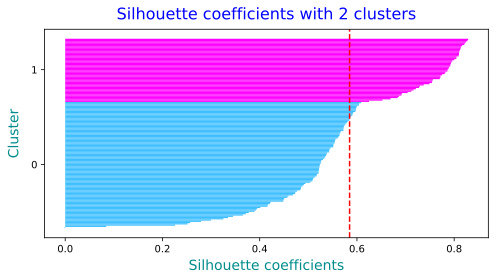

In [8]:
km_2 = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km_2 = km_2.fit_predict(X)

silhouette_vals = silhouette_samples(X, y_km_2)
silhouette_avg = np.mean(silhouette_vals)
print(BB + "\tThe average silhouette score is :" + MB, silhouette_avg, "\n")

cluster_colors = [cmap(0.25), cmap(0.999)]

plt.figure(figsize=(7, 4))
plt.title("Silhouette coefficients with 2 clusters", fontsize=16, color='blue', pad=10)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(np.unique(y_km_2)):
    c_silhouette_vals = silhouette_vals[y_km_2 == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none',
             color=cluster_colors[i])
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, np.unique(y_km_2))
plt.xlabel("Silhouette coefficients", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Cluster", labelpad=10, fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. HIERARCHICAL CLUSTERING</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. The merging algorithm</font><a id="2a"></a></p>$\quad$
        The two main approaches to <font color='darkpink'>hierarchical clustering</font> are agglomerative and divisive hierarchical clustering. In <font color='darkpink'>divisive hierarchical clustering</font>, we start with one cluster that encompasses the entire dataset, and we iteratively split the cluster into smaller clusters until each cluster contains only one example. In this chapter, we will focus on <font color='darkpink'>agglomerative clustering</font>, which takes the opposite approach. We start with each example as an individual cluster; then at each step we merge the two closest clusters (in a sense defined below) until all data points are in a single cluster.<br>$\quad$
        Thus hierarchical clustering algorithms do not require us to specify the number of clusters, contrary to k-means algorithms. Additionally, we can follow the building of the clusters using dendrograms (see the next subchapter), which can help with the interpretation of the results by creating meaningful taxonomies.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In the presentation above "closest" should be defined. The two standard criterions for agglomerative hierarchical clustering are <font color='purple'>single linkage</font> and <font color='purple'>complete linkage</font>.<br>
    <font color='darkpink'>Single linkage</font> defines the distance between two clusters A and B as<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$d_s(A,B) \;=\; \min_{\substack{a \in A,\, b \in B}}\; d(a,b) \qquad (3)$$</font>
    where $d(a,b)$ is the distance, usually the Euclidean distance, between the data points $a$ and $b$.<br>
    While <font color='darkpink'>complete linkage</font> defines the distance between two clusters A and B as<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$d_c(A,B) \;=\; \max_{\substack{a \in A,\, b \in B}}\; d(a,b) \qquad (4)$$

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>Comparative example</font> : Suppose we have <font color='#cc33ff'>$5$ data points on a line</font> (single feature case) : <font color='#1aabff'>$\,A(0)\,$</font>, <font color='#1aabff'>$\,B(1)\,$</font>, <font color='#1aabff'>$\,C(2)\,$</font>, <font color='#1aabff'>$\,D(10)\,$</font> and <font color='#1aabff'>$\,E(11)\,$</font>.<br>
        <font color='#cc33ff'>Single linkage</font> :<ol style="margin-top: 5px">
    <li>here, there are several <font color='#cc33ff'>clusters</font> separated by the minimal distance ($1$) : <font color='#1aabff'>$\,A\,$</font> and <font color='#1aabff'>$\,B\,$</font>, <font color='#1aabff'>$\,B\,$</font> and <font color='#1aabff'>$\,C\,$</font>, and <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font>; in such a case, the merge contains the first data point in the initial list of data points, so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B\}\,$</font>, <font color='#1aabff'>$\,C\,$</font>, <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font></li>
    <li>here again, there are several <font color='#cc33ff'>clusters</font> separated by the minimal distance (still $1$) : <font color='#1aabff'>$\,\{\!A,B\}\,$</font> and <font color='#1aabff'>$\,C\,$</font>, and <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font>; again, the merge contains the first data point in the initial list of data points, even if it is already inside a cluster, so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B,C\}\,$</font>, <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font></li>
    <li>this time, there are only two <font color='#cc33ff'>clusters</font> separated by the minimal distance (still $1$) : <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font> (the distance between <font color='#1aabff'>$\{\!A,B,C\}$</font> and <font color='#1aabff'>$D\,$</font> is $8$, and the distance between <font color='#1aabff'>$\{\!A,B,C\}$</font> and <font color='#1aabff'>$E\,$</font> is $9$); so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B,C\}\,$</font> and <font color='#1aabff'>$\,\{\!D,E\}\,$</font></li>
    <li>only two <font color='#cc33ff'>clusters</font> remain, only one merge is possible; we get the <font color='#cc33ff'>cluster</font> <font color='#1aabff'>$\,\{\!A,B,C,D,E\}\,$</font></li></ol>
        <font color='#cc33ff'>Complete linkage</font> :<ol style="margin-top: 5px">
    <li>there are several <font color='#cc33ff'>clusters</font> separated by the minimal distance ($1$) : <font color='#1aabff'>$\,A\,$</font> and <font color='#1aabff'>$\,B\,$</font>, <font color='#1aabff'>$\,B\,$</font> and <font color='#1aabff'>$\,C\,$</font>, and <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font>; so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B\}\,$</font>, <font color='#1aabff'>$\,C\,$</font>, <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font></li>
    <li>this time, the distance between the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B\}\,$</font> and <font color='#1aabff'>$\,C\,$</font> is equal to $2$ (since <font color='#1aabff'>$d(A,C)\!=\!2$</font>), while the distance between <font color='#1aabff'>$\,D\,$</font> and <font color='#1aabff'>$\,E\,$</font> is only 1; so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B\}\,$</font>, <font color='#1aabff'>$\,C\,$</font> and <font color='#1aabff'>$\,\{\!D,E\}\,$</font></li>
    <li>the two closest <font color='#cc33ff'>clusters</font> are <font color='#1aabff'>$\,\{\!A,B\}\,$</font> and <font color='#1aabff'>$\,C\,$</font>; so we get the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$\,\{\!A,B,C\}\,$</font> and <font color='#1aabff'>$\,\{\!D,E\}\,$</font></li>
    <li>only two <font color='#cc33ff'>clusters</font> remain, only one merge is possible; we get the <font color='#cc33ff'>cluster</font> <font color='#1aabff'>$\,\{\!A,B,C,D,E\}\,$</font></li></ol>$\quad$
        Both methods yield the same results, except at step $2$. We can see that <font color='#cc33ff'>single linkage</font> tends to create <font color='#cc33ff'>elongated clusters</font> because, when computing the distance between two <font color='#cc33ff'>clusters</font>, it uses the two <font color='#cc33ff'>closest points</font>. This can lead to the <font color='darkpink'>chaining effect</font>, where <font color='#cc33ff'>clusters</font> grow big by incorporating the closest points one by one. By contrast, <font color='#cc33ff'>complete linkage</font>, by using the two <font color='#cc33ff'>farthest points</font>, leads to smaller <font color='#cc33ff'>clusters</font>; but they will more easily incorporate <font color='#cc33ff'>outliers</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        There are two other common linkage methods : <font color='darkpink'>average linkage</font> and <font color='darkpink'>Ward's linkage</font>.<br>$\quad$
        <font color='#cc33ff'>Average linkage</font> balances the effects of single and complete linkage, leading to <font color='#cc33ff'>moderate cluster shapes</font>, by defining the distance between two clusters <font color='#1aabff'>$\,A\,$</font> and <font color='#1aabff'>$\,B\,$</font> as the average distance between all pairs of data points in the two clusters :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$d_a(A,B) \;\;=\;\; \frac{1}{|A|\,.|B|} \;\sum_{a \in A} \sum_{b \in B} d(a,b) \qquad\quad (7)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$|A|$</font> and <font color='#1aabff'>$|B|$</font> are the cardinalities of <font color='#1aabff'>$A\,$</font> and <font color='#1aabff'>$B\,$</font> respectively.<br><br>$\quad$
        In <font color='#cc33ff'>Ward's linkage</font>, the two clusters that lead to the minimum increase of the <font color='#cc33ff'>total $SSE\,$</font> are merged (for the definition of <font color='#cc33ff'>$SSE\,$</font>, see "1a. k-means clustering using scikit-learn", equation $(1)$). Let's explain the method succinctly. Since the <font color='#cc33ff'>Ward's linkage</font> uses the <font color='#cc33ff'>$SSE\,$</font>, we first need to define a centroid for each <font color='#cc33ff'>cluster</font> <font color='#1aabff'>$C\,$</font>; it will always be the arithmetic mean of the points in <font color='#1aabff'>$C\,$</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\mu_C \;\;=\;\; \frac{1}{|C|} \; \sum_{x \in C} x \qquad\quad (8)$$</font><div style="margin-top: 10px"></div>$\quad$
        In this context, we often denote by <font color='darkpink'>$\, SSE(C) \,$</font> the <font color='#cc33ff'>$SSE\,$</font> of the <font color='#cc33ff'>cluster</font> <font color='#1aabff'>$C\,$</font>, so that equation $(1)$ gives the <font color='#cc33ff'>total $SSE\,$</font> as the sum of its <font color='#cc33ff'>cluster's $SSE\,$</font>, <font color='#1aabff'>$\,SSE = \sum_{j=1}^k SSE(C_j) \,$</font>. The <font color='darkpink'>dissimilarity $\delta(A,B)$</font> between the <font color='#cc33ff'>clusters</font> <font color='#1aabff'>$A\,$</font> and <font color='#1aabff'>$B\,$</font> is the increase in <font color='#cc33ff'>total $SSE\,$</font> caused by the merging of <font color='#1aabff'>$A\,$</font> and <font color='#1aabff'>$B\,$</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\begin{align} \delta(A,B) & \;\;=\;\; SSE(A \cup B) - SSE(A) - SSE(B) \\\\ & \;\;=\;\; \sum_{x \in A} \,\left(\lVert x - \mu_{A \cup B} \rVert_2^2 - \lVert x - \mu_A \rVert_2^2 \right) \;+\; \sum_{x \in B} \,\left(\lVert x - \mu_{A \cup B} \rVert_2^2 - \lVert x - \mu_B \rVert_2^2 \right) \\\\ & \;\;=\;\; |A|\,.\,\lVert \mu_A - \mu_{A \cup B} \rVert_2^2 \;+\; |B|\,.\,\lVert \mu_B - \mu_{A \cup B} \rVert_2^2 \qquad\quad (9) \end{align}$$</font><div style="margin-top: 10px"></div>
    where the third equality comes from the bilinearity and symmetry of the scalar product and from the fact that <font color='#1aabff'>$\mu_A$</font> (resp. <font color='#1aabff'>$\mu_B$</font>) is the mean of the <font color='#1aabff'>$x$</font> in <font color='#1aabff'>$A$</font> (resp. <font color='#1aabff'>$B$</font>), and holds for any <font color='#1aabff'>$\,\mu \in \mathbb{R}^n \,$</font> (<font color='#1aabff'>$n$</font> being the number of features) instead of <font color='#1aabff'>$\mu_{A \cup B}$</font> :<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{align} \sum_{x \in A}\; \lVert x - \mu \rVert_2^2 & \;\;=\;\; \sum_{x \in A}\; \lVert x - \mu_A \rVert_2^2 \;+\; 2 \;\sum_{x \in A}\, \left(x-\mu_A\,,\,\mu_A-\mu\right) \;+\; \sum_{x \in A}\; \lVert \mu_A - \mu \rVert_2^2 \\\\ & \;\;=\;\; \sum_{x \in A}\; \lVert x - \mu_A \rVert_2^2 \;+\; 2 \,\left(0\,,\,\mu_A-\mu\right) \;+\; \sum_{x \in A}\; \lVert \mu_A - \mu \rVert_2^2 \\\\ & \;\;=\;\; \sum_{x \in A}\; \lVert x - \mu_A \rVert_2^2 \;+\; |A| \,.\, \lVert \mu_A - \mu \rVert_2^2 \qquad\quad (10) \end{align}$$</font><div style="margin-top: 10px"></div>$\quad$
    $(9)$ implies that the <font color='#cc33ff'>total $SSE\,$</font> increases each time that two <font color='#cc33ff'>clusters</font> are merged; it starts at $0$ - since each point is a <font color='#cc33ff'>cluster</font> -, and ends at <font color='#1aabff'>$\, \sum_{i=1}^m \lVert x^{(i)} - \mu \rVert_2^2 \,$</font> (where <font color='#1aabff'>$\mu$</font> is the global mean) - since the whole dataset is a single cluster -. The <font color='#cc33ff'>Ward's linkage</font> consists in choosing, at each merge, the one that results in the minimum increase of the <font color='#cc33ff'>total $SSE\,$</font>, ie the two <font color='#cc33ff'>clusters</font> that have the <font color='#cc33ff'>smallest dissimilarity</font>.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. Building dendrograms with SciPy</font><a id="2b"></a></p>$\quad$
        The goal of this subchapter is to introduce <font color='darkpink'>dendrograms</font> and how to build them. <font color='#cc33ff'>Dendrograms</font> are diagrams, and to display them fully, we need a very small dataset (or sub-dataset). Therefore, we first create a dataset with $10$ instances described by $3$ features; its values are randomly drawn from a uniform distribution over $[0,10[$. We assign labels to our instances, the <font color='#1aabff'>$i$</font>-th instance label being <font color='#1aabff'>ID_i</font> :

In [9]:
# Generate random data
np.random.seed(123)
n_ex = 10
features = ['X', 'Y', 'Z']
# the names of the data points will be ID_0 through ID_(n_ex-1)
labels = [f'ID_{i}' for i in range(n_ex)]
# Generate a NumPy array of shape (n_ex,3) of random numbers uniformly chosen in [0,10[
X = np.random.random_sample([n_ex, 3]) * 10
# creates a Pandas dataframe 'df' using the generated random data 'X'. The 'columns' parameter assigns
# the column names ('X', 'Y', 'Z'), and the index parameter assigns the row labels ('ID_0' to 'ID_(n_ex-1)')
df = pd.DataFrame(X, columns=features, index=labels)

# Apply our 'beautify' function (from cell 1) to render the dataframe
print(BB + "The head of our dataset :\n")
beautify(df.head())

The head of our dataset :



,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>Dendrograms</font> represent a <font color='#cc33ff'>sequence of consecutive mergings</font>. We will build our <font color='#cc33ff'>dendrograms</font> with <font color='#cc33ff'>SciPy</font>, and, in <font color='#cc33ff'>SciPy</font>, a <font color='#cc33ff'>dendrogram</font> is based on a matrix called the <font color='darkpink'>linkage matrix</font>. A <font color='#cc33ff'>linkage matrix</font> describes the <font color='#cc33ff'>cluster merging process</font>. It has <font color='#1aabff'>$n\!-\!1$</font> rows (where <font color='#1aabff'>$n$</font> is the number of instances in the training set), one per <font color='#cc33ff'>merging step</font>. Initially, there are <font color='#1aabff'>$n$</font> instances, hence <font color='#1aabff'>$n$</font> <font color='#cc33ff'>individual clusters</font>; at each step, two <font color='#cc33ff'>clusters</font> are merged, so there is $1$ fewer <font color='#cc33ff'>cluster</font>, and after <font color='#1aabff'>$n\!-\!1$</font> steps, the whole training set forms a <font color='#cc33ff'>single cluster</font>. Each row has $4$ columns; they describe the <font color='#cc33ff'>merging step</font> : the first two hold the indices of the <font color='#cc33ff'>clusters</font> being merged; the third contains the distance or <font color='#cc33ff'>dissimilarity</font> between both <font color='#cc33ff'>clusters</font> (distance according to the specified metric <font color='#1aabff'>$d$</font> for the <font color='#cc33ff'>single linkage</font>, <font color='#cc33ff'>complete linkage</font> or <font color='#cc33ff'>average linkage</font> methods; <font color='#cc33ff'>dissimilarity</font> for the <font color='#cc33ff'>Ward's linkage</font>); and the last indicates the total number of data points contained in the <font color='#cc33ff'>merged cluster</font>.<div style="margin-top: 20px"></div>$\quad$
        We can get the <font color='#cc33ff'>linkage matrix</font> of our training set using the <font color='#cc33ff'>linkage(y, method='single', metric='euclidean')</font> function from <font color='#cc33ff'>SciPy</font>'s <font color='#cc33ff'>cluster.hierarchy</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>y</font> : either a 2D NumPy array, in which case it must be our dataset, or the 1D Numpy array of the coefficients of the upper triangular matrix of the distances between the data points (excluding the diagonal)</li>
    <li><font color='#cc33ff'>method='single'</font> : the method to use to merge the <font color='#cc33ff'>clusters</font>. It can be <font color='#cc33ff'>method=</font><font color='#1aabff'>'single'</font> (the default) for <font color='#cc33ff'>single linkage</font>, <font color='#cc33ff'>method=</font><font color='#1aabff'>'complete'</font> for <font color='#cc33ff'>complete linkage</font>, <font color='#cc33ff'>method=</font><font color='#1aabff'>'average'</font> for <font color='#cc33ff'>average linkage</font>, <font color='#cc33ff'>method=</font><font color='#1aabff'>'ward'</font> for <font color='#cc33ff'>Ward's linkage</font>, among others</li>
    <li><font color='#cc33ff'>metric='euclidean'</font> : the distance metric to use when <font color='#cc33ff'>y</font> is our dataset, and should be ignored otherwise. There are many possible distance metrics but <font color='#cc33ff'>metric=</font><font color='#1aabff'>'euclidean'</font> is by far the most common</li></ul>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Once the <font color='#cc33ff'>linkage matrix</font> has been computed, we can plot a <font color='#cc33ff'>dendrogram</font>. A <font color='#cc33ff'>dendrogram</font> is a tree-like diagram used to illustrate the <font color='#cc33ff'>arrangement of clusters</font> produced by <font color='#cc33ff'>hierarchical clustering</font>. It consists of pairs of branches. Each pair joins <font color='#cc33ff'>two clusters</font> together; their height represents either the distance (in distance-based linkage methods) or the <font color='#cc33ff'>dissimilarity</font> (eg in <font color='#cc33ff'>Ward's linkage</font>) between both <font color='#cc33ff'>clusters</font>, a taller height indicating that they are more distant or dissimilar. The <font color='#cc33ff'>leaves</font> of the <font color='#cc33ff'>dendrogram</font> represent the individual data points. As we move up the tree, branches merge to form larger clusters.<br>$\quad$
        When there are many <font color='#cc33ff'>data points</font>, displaying the whole <font color='#cc33ff'>dendrogram</font> is not feasible, and we can only display the last merges. This is possible in <font color='#cc33ff'>SciPy</font>; the vertical ticks remain unchanged though : the height of a pair of branches still represents the distance (or <font color='#cc33ff'>dissimilarity</font>) between two <font color='#cc33ff'>clusters</font>, but the branches still start at height $0$, which obviously does not mean that the distances within the <font color='#cc33ff'>merged clusters</font> are $0$; if needed, we can get the <font color='#cc33ff'>true within-cluster distances</font> by using the <font color='#cc33ff'>linkage matrix</font>.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can plot the <font color='#cc33ff'>dendrogram</font> of a dataset by using the <font color='#cc33ff'>dendrogram(Z, p=30, truncate_mode=None, orientation='top', labels=None, show_leaf_counts=True, no_labels=False, leaf_font_size=None, leaf_rotation=None)</font> function from <font color='#cc33ff'>SciPy</font>'s <font color='#cc33ff'>cluster.hierarchy</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>Z</font> : the <font color='#cc33ff'>linkage matrix</font></li>
    <li><font color='#cc33ff'>p</font> : the parameter for <font color='#cc33ff'>truncate_mode</font> (see next line)</li>
    <li><font color='#cc33ff'>truncate_mode=None</font> : used to cut the <font color='#cc33ff'>dendrogram</font> and only show its top-most part. <font color='#cc33ff'>truncate_mode=</font><font color='#1aabff'>None</font> (the default) displays the whole <font color='#cc33ff'>dendrogram</font>; <font color='#cc33ff'>truncate_mode=</font><font color='#1aabff'>lastp</font> displays the cluster merging process once there remain only <font color='#1aabff'>$p$</font> (the value of the parameter <font color='#cc33ff'>p</font>) clusters (or, equivalently, it displays the last <font color='#1aabff'>$p\!-\!1$</font> merges); and <font color='#cc33ff'>truncate_mode=</font><font color='#1aabff'>level</font> displays the last <font color='#1aabff'>$p$</font> levels, ie the <font color='#cc33ff'>dendrogram</font> starting with all the clusters that will be part of the final <font color='#cc33ff'>single cluster</font> within at most <font color='#1aabff'>$p$</font> <font color='#cc33ff'>merging steps</font></li>
    <li><font color='#cc33ff'>orientation='top'</font> : the direction to use to plot the <font color='#cc33ff'>dendrogram</font>, by indicating the place of the <font color='#cc33ff'>dendrogram</font>'s root. There are 4 possibilities : <font color='#cc33ff'>orientation=</font><font color='#1aabff'>'top'</font> (the default), <font color='#cc33ff'>orientation=</font><font color='#1aabff'>'bottom'</font>, <font color='#cc33ff'>orientation=</font><font color='#1aabff'>'left'</font>, and <font color='#cc33ff'>orientation=</font><font color='#1aabff'>'right'</font></li>
    <li><font color='#cc33ff'>labels=None</font> : the names to give to the data points; <font color='#cc33ff'>labels=</font><font color='#1aabff'>None</font> means that their names will be their indices in the original list of data points; otherwise it should be a 1D array of strings of size the number <font color='#1aabff'>$n$</font> of examples. If we want no labels at all, we use the <font color='#cc33ff'>no_labels</font> parameter (see below)</li>
    <li><font color='#cc33ff'>show_leaf_counts=True</font> : whether or not the <font color='#cc33ff'>merged clusters</font> have a name; by default, they have one and it is the number of data points they contain, including those that have already been merged into <font color='#cc33ff'>clusters</font>, between parentheses</li>
    <li><font color='#cc33ff'>no_labels=False</font> : whether or not the function should remove the data points' labels</li>
    <li><font color='#cc33ff'>leaf_font_size=None</font> : the font size (in points) of the <font color='#cc33ff'>leaves' labels</font>. By default, the size is based on the number of <font color='#cc33ff'>nodes</font> in the <font color='#cc33ff'>dendrogram</font></li>
    <li><font color='#cc33ff'>leaf_rotation=None</font> specifies the angle (in degrees) to rotate the <font color='#cc33ff'>leaves' labels</font>; it can be any double; the default corresponds to a rotation of $0°$</li></ul><div style="margin-top: 20px"></div>$\quad$
        The <font color='#cc33ff'>dendrogram</font> function returns a dictionary with these key:value pairs :<ul>
    <li><font color='#cc33ff'>'leaves'</font> : the list that specifies the order of the <font color='#cc33ff'>leaves</font> from left to right in the <font color='#cc33ff'>dendrogram</font></li>
    <li><font color='#cc33ff'>'ivl'</font> : the list of labels corresponding to the <font color='#cc33ff'>leaves</font></li>
    <li><font color='#cc33ff'>'icoord'</font> and <font color='#cc33ff'>'dcoord'</font> : if the <font color='#cc33ff'>dendrogram</font> starts when it remains <font color='#1aabff'>$p$</font> clusters (<font color='#1aabff'>$\,2 \leq p \leq n\,$</font>), then <font color='#cc33ff'>'icoord'</font> and <font color='#cc33ff'>'dcoord'</font> are of the form <font color='#cc33ff'>icoord</font> = <font color='#1aabff'>$\,[I_1, \cdots, I_{p-1}]$</font> and <font color='#cc33ff'>dcoord</font> = <font color='#1aabff'>$\,[D_1, \cdots, D_{p-1}]\,$</font> where any <font color='#1aabff'>$I_k$</font> is of the form <font color='#1aabff'>$I_k = [x_{k,1}\,,\, x_{k,2}\,,\, x_{k,3}\,,\, x_{k,4}]$</font> and any <font color='#1aabff'>$D_k$</font> is of the form <font color='#1aabff'>$D_k = [y_{k,1}\,,\, y_{k,2}\,,\, y_{k,3}\,,\, y_{k,4}]$</font>; the <font color='#1aabff'>$k$</font>-th link (the 3 line segments representing the two branches joining the two clusters merged at step <font color='#1aabff'>$k$</font>) starts at <font color='#1aabff'>$(x_{k,1}\,,\, y_{k,1})$</font> then goes up to <font color='#1aabff'>$(x_{k,2}\,,\, y_{k,2})$</font> (it is a vertical line segment so <font color='#1aabff'>$x_{k,2}=x_{k,1}$</font>), then goes right to <font color='#1aabff'>$(x_{k,3}\,,\, y_{k,3})$</font> (with <font color='#1aabff'>$y_{k,3}=y_{k,2}$</font>), then goes down to <font color='#1aabff'>$(x_{k,4}\,,\, y_{k,4})$</font> (with <font color='#1aabff'>$x_{k,4}=x_{k,3}$</font>)</li>
    <li><font color='#cc33ff'>'color_list'</font> : the list of color names whose <font color='#1aabff'>$k$</font>-th element represents the color of the <font color='#1aabff'>$k$</font>-th link</li>
    <li><font color='#cc33ff'>'leaves_color_list'</font> : the list of color names whose <font color='#1aabff'>$k$</font>-th element represents the color of the <font color='#1aabff'>$k$</font>-th leaf</li></ul><div style="margin-top: 20px"></div>$\quad$
        This will all be clearer after a few examples. Let's plot three <font color='#cc33ff'>dendrograms</font> based on our data sample; one <font color='#cc33ff'>full dendrogram</font> and two truncated ones :

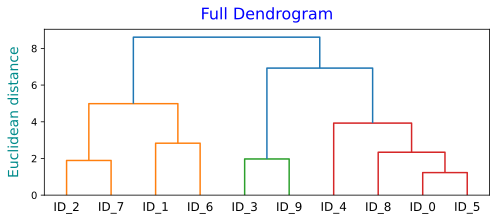

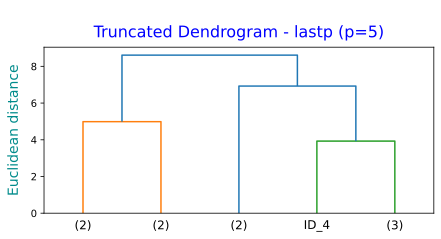

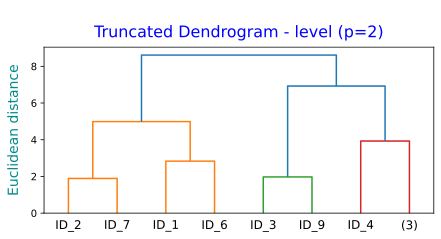

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
row_clusters = linkage(df.values, method='complete', metric='euclidean')

# Plot full dendrogram
plt.figure(figsize=(8,3))
plt.title("Full Dendrogram", fontsize=16, color='blue', pad=10)
plt.ylabel("Euclidean distance", labelpad=10, fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels)
plt.show()

# Plot truncated dendrogram using 'lastp' with p=5
plt.figure(figsize=(7,3))
plt.title("\nTruncated Dendrogram - lastp (p=5)", fontsize=16, color='blue', pad=10)
plt.ylabel("Euclidean distance", labelpad=10, fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels, truncate_mode='lastp', p=5)
plt.show()

# Plot truncated dendrogram using 'level' with p=2
plt.figure(figsize=(7,3))
plt.title("\nTruncated Dendrogram - level (p=2)", fontsize=16, color='blue', pad=10)
plt.ylabel("Euclidean distance", labelpad=10, fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels, truncate_mode='level', p=2)
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        According to the heights of their branches, we see that the two closest data points are <font color='#5555ff'>ID_0</font> and <font color='#5555ff'>ID_5</font>, followed by <font color='#5555ff'>ID_2</font> and <font color='#5555ff'>ID_7</font>, and then <font color='#5555ff'>ID_3</font> and <font color='#5555ff'>ID_9</font>,... Also, the distance within the cluster {<font color='#5555ff'>ID_0</font>, <font color='#5555ff'>ID_5</font>, <font color='#5555ff'>ID_8</font>} is less than the distance between <font color='#5555ff'>ID_1</font> and <font color='#5555ff'>ID_6</font>.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Attaching a heatmap to a dendrogram</font><a id="2c"></a></p>$\quad$
        In practical applications, <font color='#cc33ff'>hierarchical clustering dendrograms</font> are often used in combination with a <font color='#cc33ff'>heatmap</font> of the matrix containing the data points, where each cell's color reflects the magnitude of the corresponding data value (with my favorite <font color='#cc33ff'>cmap</font>, colors go from neon blue to magenta in increasing order of the values they represent; if you prefer, you can use the "hot_r" color map, as explained within the code, to get darker cells for larger values).<br>$\quad$
        In order to link both the <font color='#cc33ff'>dendrogram</font> and the data matrix, we reorder the rows of the matrix to coincide with the rearrangement done by the <font color='#cc33ff'>cluster merging process</font>. Also, we choose the same height for both diagrams; since both the <font color='#cc33ff'>dendrogram</font> and the <font color='#cc33ff'>heatmap</font> allocate equal vertical space per row, their rows will indeed align precisely when plotted with the same total height; and will appear one in front of the other since we draw both diagrams side by side :

In [11]:
fig = plt.figure(figsize=(8, 8))

# Add a subplot for the dendrogram (I have changed the location parameters to avoid overlapping of the
# subplots and to get a clearer dendrogram)
# Add a new set of axes to the figure 'fig' and assigns it to the variable 'axd'. The 'add_axes'
# method takes a list of four values [left, bottom, width, height] that define the position and size of
# a new subplot in the figure. These values are fractions of the figure's width and height; thus
# 'left=0.2' means the left edge of the subplot is 20% of the 'fig' width from the left edge of 'fig',
# 'bottom=0.1' means the bottom edge of the subplot is 10% of the 'fig' height from the bottom edge of
# 'fig', 'width=0.3' means the subplot's width is 30% of the 'fig' width, and height=0.6 means the
# subplot's height is 60% of the 'fig' height...
# At least, this is the theory; in a Jupyter notebook, although 'left=0.2', the subplot will start at
# 'left=0'... In order to get margins and center the figure, I save it and use html/css. The saved
# figure has no margins either, and using 'axd = fig.add_axes([0.2, 0.1, 0.3, 0.6])' together with
# 'axm = fig.add_axes([0.45, 0.1, 0.4, 0.6])' saves the same figure as using
# 'axd = fig.add_axes([0., 0.1, 0.3, 0.6])' together with 'axd = fig.add_axes([0.25, 0.1, 0.3, 0.6])'...
# I have asked ChatGPT and Deepseek R1, and they have no clear answer...
axd = fig.add_axes([0.2, 0.1, 0.3, 0.6])
#  this 'dendrogram' call generates a dendrogram for our data points using the linkage matrix
# 'row_clusters' (from cell 10), oriented with the root on the left, so the dendrogram is horizontal and
# the data points appear on the right. Moreover its return value, a dictionary that we will use below, is
# saved under the name 'row_dendr' (see "2b. Building dendrograms with SciPy" for its precise content)
row_dendr = dendrogram(row_clusters, orientation='left')
# 'row_dendr['leaves']' is the order of the data points in the dendrogram; '[::-1]' reverses this order
# because the rotation of the dendrogram makes the last data points appear on top, while the heatmap
# will preserve the disposition of the matrix rows (with the first rows on top) and we want the data
# points in both diagrams to coincide horizontally; then 'df.iloc' reorders the rows of the original
# dataframe 'df' following this order; the result is assigned to 'df_rowclust'
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

# Customize the appearance of the dendrogram
# Remove the x-ticks (ie the Euclidean distances)
axd.set_xticks([])
# Remove the y-ticks (ie the data points' names); we will use those provided by the heatmap instead
axd.set_yticks([])
# removes the border lines around the dendrogram plot
for spine in axd.spines.values():
    spine.set_visible(False)

# Add a subplot for the heatmap
# the heatmap is contiguous to the dendrogram so the rows' names can be easily associated with the
# dendrogram's leaves' names; both subplots start at the same height (0.1) and have identical heights
# (0.6), ensuring horizontal alignments of their rows
axm = fig.add_axes([0.45, 0.1, 0.4, 0.6])
# Display the heatmap using 'matshow', which visualizes 'df_rowclust' as a matrix of colors.
# 'interpolation='nearest'' ensures sharp boundaries between cells,
# You may use 'cmap='hot_r'', if you want darker colors to correspond to larger values, instead of my
# "cyberpunk" colors that go from  neon blue to magenta
# 'cax' is the matplotlib object associated with the heatmap
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap=cmap)
# Add a colorbar to the heatmap to indicate the mapping of colors to values
fig.colorbar(cax)

# Customize the appearance of the heatmap
# in Pandas, the label of a row (resp. column) is called an 'index' (resp. a 'column'). For example
# 'df_rowclust.index' (resp. 'df_rowclust.columns') is the list of the rows' (resp. columns') labels in
# the dataframe 'df_rowclust'. Here we want to display them with the heatmap.
# First, we need to set the ticks; this is done by generating a sequence of integers starting from 0 up
# to len(df_rowclust.columns)-1 for the x-ticks and then applying the 'set_xticks' function :
axm.set_xticks(range(len(df_rowclust.columns)))
# there are len(df_rowclust.index) vertical ticks :
axm.set_yticks(range(len(df_rowclust.index)))
# and now we can assign these ticks their corresponding labels :
axm.set_xticklabels(df_rowclust.columns)
axm.set_yticklabels(df_rowclust.index)

# this is done to center the figure. You can run 'plt.show()' instead if you don't want to save the figure
plt.savefig('figure.png', bbox_inches='tight')  # Save the figure with all margins
from IPython.display import display, HTML
# Close the figure to prevent it from being displayed twice
plt.close(fig)
# Display the image with HTML/CSS for centering and resizing
display(HTML(f"""
    <div style="display: flex; justify-content: center;">
        <img src="{'figure.png'}" style="width: 45%; height: 45%"></div>"""))

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Agglomerative clustering with scikit-learn</font><a id="2d"></a></p>$\quad$
        In "2b. Building dendrograms with SciPy" we have used <font color='#cc33ff'>SciPy</font> to perform a detailed <font color='#cc33ff'>cluster merging process</font>, starting with every data point as a simple <font color='#cc33ff'>cluster</font> and <font color='#cc33ff'>merging</font> at each step the two closest (or less dissimilar) <font color='#cc33ff'>clusters</font>, up to the point where only a <font color='#cc33ff'>single cluster</font> remained, containing all the data points. This <font color='#cc33ff'>merging process</font> is stored in a <font color='darkpink'>linkage matrix</font>; each row of the matrix corresponds to a <font color='#cc33ff'>single merging</font>, and informs on the two clusters that have been merged, their initial distance (or <font color='#cc33ff'>dissimilarity</font>), and the data points their union holds. A <font color='#cc33ff'>dendrogram</font> allows a visual representation of the <font color='darkpink'>linkage matrix</font>, or of its last rows when the number of instances is too large for the <font color='#cc33ff'>dendrogram</font> to be represented clearly.<br>$\quad$
        These tools are great to represent the <font color='#cc33ff'>merging process</font> and visualize the distances between the merged clusters, but not very practical if we want to know how our instances should be arranged if we want to split them into a certain number of groups, say <font color='#1aabff'>$k$</font>. In this case, it would be better to use the <font color='#cc33ff'>k-means algorithm</font>, via <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>KMeans</font> class presented in "1a. k-means clustering using scikit-learn". However, the groupings obtained with <font color='#cc33ff'>KMeans</font> may be very different from one value of <font color='#1aabff'>$k$</font> to the next, and it is not possible to perform an <font color='#cc33ff'>agglomerative clustering</font> using <font color='#cc33ff'>KMeans</font>. Not all is lost, though : <font color='#cc33ff'>scikit-learn</font> offers a class to perform an <font color='#cc33ff'>agglomerative clustering</font> and easily learn how our instances are split if we use <font color='#1aabff'>$k$</font> clusters, whatever the value of <font color='#1aabff'>$k$</font> : <font color='#cc33ff'>AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')</font>, from its <font color='#cc33ff'>cluster</font> module. Note that this class has no <font color='#cc33ff'>dendrograms</font>, though, so <font color='#cc33ff'>linkage</font>, <font color='#cc33ff'>dendrogram</font> and <font color='#cc33ff'>AgglomerativeClustering</font> are complementary tools. For our new class, I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>n_clusters=2</font> : the number <font color='#1aabff'>$k$</font> of (remaining) clusters; <font color='#1aabff'>$\,k\!=\!2\,$</font> by default</li>
    <li><font color='#cc33ff'>metric='euclidean'</font> : the metric to use to perform the mergings. The default is <font color='#cc33ff'>metric=</font><font color='#1aabff'>'euclidean'</font>; other possibilities are <font color='#cc33ff'>metric=</font><font color='#1aabff'>'l1'</font>, <font color='#cc33ff'>metric=</font><font color='#1aabff'>'l2'</font> (an equivalent for <font color='#cc33ff'>metric=</font><font color='#1aabff'>'euclidean'</font>) or <font color='#cc33ff'>metric=</font><font color='#1aabff'>'cosine'</font> (where the distance between two clusters is their <font color='darkpink'>cosine distance</font>; the <font color='#cc33ff'>cosine distance between two vectors</font> <font color='#1aabff'>$u$</font> and <font color='#1aabff'>$v$</font> is defined as <font color='darkpink'>$\; 1-\frac{u\,.\,v}{\Vert u \Vert \, \Vert v \Vert}$</font>). If we want to use the <font color='#cc33ff'>Ward's linkage</font> (see "2a. The merging algorithm") then we should use <font color='#cc33ff'>metric=</font><font color='#1aabff'>'euclidean'</font> (the default)</li>
    <li><font color='#cc33ff'>linkage='ward'</font> specifies the criterion to use to perform the mergings. The default is <font color='#cc33ff'>linkage=</font><font color='#1aabff'>'ward'</font>; other possibilities are <font color='#cc33ff'>linkage=</font><font color='#1aabff'>'single'</font>, <font color='#cc33ff'>linkage=</font><font color='#1aabff'>'complete'</font>, or <font color='#cc33ff'>linkage=</font><font color='#1aabff'>'average'</font></li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following methods and attributes available through <font color='#cc33ff'>AgglomerativeClustering</font> :<ul>
    <li><font color='#cc33ff'>.fit(X)</font> : determines the <font color='#1aabff'>$k$</font> clusters (obtained by the <font color='#cc33ff'>linkage</font> method, using the metric specified in <font color='#cc33ff'>metric</font>) to split the instances of the training matrix <font color='#1aabff'>$X$</font>; the <font color='#cc33ff'>clusters</font> are referenced by an index, starting at $0$</li>
    <li><font color='#cc33ff'>.fit_predict(X)</font> : runs <font color='#cc33ff'>.fit(X)</font> and then returns <font color='#cc33ff'>labels_</font> (see next line)</li>
    <li><font color='#cc33ff'>labels_</font> : the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the index of the <font color='#cc33ff'>cluster</font> containing <font color='#1aabff'>$x^{(i)}$</font></li>
        After training, the <font color='#cc33ff'>labels_</font> attribute returns the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the index of the <font color='#cc33ff'>cluster</font> containing <font color='#1aabff'>$x^{(i)}$</font>.<div style="margin-top: 20px"></div>$\quad$
        For example, if we want to group our data points in three <font color='#cc33ff'>clusters</font> using the <font color='#cc33ff'>complete linkage</font> method (see "2a. The merging algorithm") with the Euclidean metric, we can do :


In [12]:
from sklearn.cluster import AgglomerativeClustering

ac_3 = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
labels = ac_3.fit_predict(X)
print(BB + "After training with " + MB + "3 clusters" + BB + ", our instances are assigned to the clusters labeled :" + MB, labels)

ac_2 = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
labels = ac_2.fit_predict(X)
print(BB + "After training with " + MB + "2 clusters" + BB + ", our instances are assigned to the clusters labeled :" + MB, labels)

After training with 3 clusters, our instances are assigned to the clusters labeled : [1 0 0 2 1 1 0 0 1 2]
After training with 2 clusters, our instances are assigned to the clusters labeled : [0 1 1 0 0 0 1 1 0 0]


<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We see that, when there are 3 clusters, they contain the instances {1, 5, 6, 9}, {2, 3, 7, 8} and {4, 10}, that we called in a coding way {<font color='#5555ff'>ID_0</font>, <font color='#5555ff'>ID_4</font>, <font color='#5555ff'>ID_5</font>, <font color='#5555ff'>ID_8</font>}, {<font color='#5555ff'>ID_1</font>, <font color='#5555ff'>ID_2</font>, <font color='#5555ff'>ID_6</font>, <font color='#5555ff'>ID_7</font>}, and {<font color='#5555ff'>ID_3</font>, <font color='#5555ff'>ID_9</font>} in the previous subchapter. This is, obviously, the same result we obtained with <font color='#cc33ff'>SciPy</font>'s <font color='#cc33ff'>dendrogram</font> (see the "Full Dendrogram" obtained in cell 10), but clearer. Also, to go from 3 to 2 clusters, the clusters {1, 5, 6, 9} and {4, 10} have been merged.<br>$\quad$
        Using this method step by step from <font color='#cc33ff'>n_clusters=</font><font color='#1aabff'>$m$</font> to <font color='#cc33ff'>n_clusters=</font><font color='#1aabff'>$2$</font> we would obtain the whole <font color='#cc33ff'>merging process</font>. But, since the computations would be done from scratch at each step, it wouldn't be efficient to do it this way.

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. DENSITY-BASED CLUSTERING WITH DBSCAN</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. The DBSCAN algorithm</font><a id="3a"></a></p>$\quad$
        As its name suggests, <font color='darkpink'>density-based clustering</font> determines <font color='#cc33ff'>clusters</font> based on <font color='#cc33ff'>dense regions of points</font>. This requires a definition of "dense region". <font color='darkpink'>DBSCAN</font> (Density-Based Spatial Clustering of Applications with Noise) considers, for each <font color='#cc33ff'>data point</font> <font color='#1aabff'>$P$</font>, the <font color='darkpink'>neighborhood of $P$</font>, ie the closed ball centered at <font color='#1aabff'>$P$</font> with radius a value <font color='#1aabff'>$\epsilon>0$</font> chosen by the user; it counts the number of <font color='#cc33ff'>data points</font> within the ball (including its center), and, if this number is at least equal to another value chosen by the user, say <font color='#1aabff'>$p$</font>, then the ball is declared <font color='#cc33ff'>dense</font>, and its center is declared a <font color='#cc33ff'>core point</font>. In fact, DBSCAN splits the <font color='#cc33ff'>data points</font> into 3 categories :<ul>
    <li>A <font color='darkpink'>core point</font> is any <font color='#cc33ff'>data point</font> with at least <font color='#1aabff'>$\,p\!-\!1\,$</font> other <font color='#cc33ff'>data points</font> in its <font color='#cc33ff'>neighborhood</font> (ie at a distance <font color='#1aabff'>$\,\leq\epsilon\,$</font>)</li>
    <li>A <font color='darkpink'>border point</font> is any <font color='#cc33ff'>data point</font> that is not a <font color='#cc33ff'>core point</font> but lies at a distance less than or equal to <font color='#1aabff'>$\epsilon$</font> from a <font color='#cc33ff'>core point</font></li>
    <li>All other <font color='#cc33ff'>data points</font> are considered <font color='darkpink'>noise points</font></li></ul>

<figure style="text-align: center;">
    <img src="10.1. Core, border and noise points for DBSCAN.png" alt="Figure showing core, border and noise points. In this example, a data point is a core point iff it has at least p=3 neighbours within a radius ε. There are three core points, each surrounded by a dashed circle of radius ε. The points that are inside an ε-disk but have fewer than p neighbours are the border points. The points that are not inside an ε-disk are the noise points." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Core, border and noise points</figcaption>
</figure>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
$\quad$
    After labeling the points as <font color='#cc33ff'>core</font>, <font color='#cc33ff'>border</font>, or <font color='#cc33ff'>noise</font>, the <font color='#cc33ff'>DBSCAN algorithm</font> consists of two simple steps :<font color='darkcyan'><ol>
<li>Create a <font color='#cc33ff'>separate cluster</font> for each group of <font color='darkpink'>density-connected core points</font>; two <font color='#cc33ff'>core points</font> are said to be <font color='#cc33ff'>density-connected</font> iff there exists a sequence of <font color='#cc33ff'>core points</font>, each within distance <font color='#1aabff'>$\epsilon$</font> of the next, linking them; a group of <font color='#cc33ff'>density-connected core points</font> may consist of a single <font color='#cc33ff'>core point</font></li>
<li>Assign each <font color='#cc33ff'>border point</font> to the <font color='#cc33ff'>cluster</font> of the first <font color='#cc33ff'>core point</font> encountered within distance <font color='#1aabff'>ε</font>, according to scikit‑learn’s scan order.</li></ol></font><div style="margin-top: 20px"></div>$\quad$
        As a result, <font color='#cc33ff'>DBSCAN</font> naturally excludes <font color='#cc33ff'>noise points</font> from the <font color='#cc33ff'>cluster formation process</font>.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Running DBSCAN on an example</font><a id="3b"></a></p>$\quad$
        Let’s create a dataset of 2D points forming two horizontal "crescent moons" with little noise to demonstrate a situation where <font color='#cc33ff'>DBSCAN</font> performs better than <font color='#cc33ff'>k-means clustering</font> and <font color='#cc33ff'>hierarchical clustering</font>, that we studied in our first two chapters. We use the <font color='#cc33ff'>make_moons</font> function from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>datasets</font> module (presented in part 3, "3c. Examples of soft margin linear classification (hyperplane and polynomial decision boundaries)") :

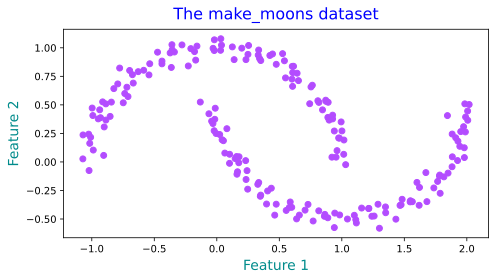

In [13]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

plt.figure(figsize=(7, 4))
plt.title("The make_moons dataset", fontsize=16, color='blue', pad=10)
plt.scatter(X[:, 0], X[:, 1], color=cmap(0.7))
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=5, fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We will start by using the <font color='#cc33ff'>k-means algorithm</font> and <font color='#cc33ff'>complete linkage clustering</font> to see if one of these previously discussed <font color='#cc33ff'>clustering algorithms</font> can successfully identify the crescent-moon shapes as <font color='#cc33ff'>two separate clusters</font> :

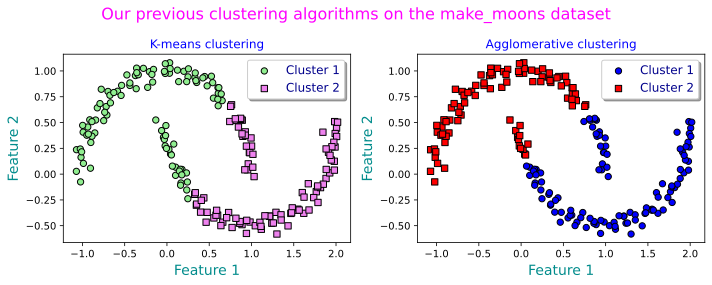

In [14]:
km_2 = KMeans(n_clusters=2, random_state=0)
y_km_2 = km_2.fit_predict(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Our previous clustering algorithms on the make_moons dataset", fontsize=16, color='magenta')
ax1.scatter(X[y_km_2 == 0, 0], X[y_km_2 == 0, 1], edgecolor='black', marker='o', s=40, color='lightgreen',
            label="Cluster 1")
ax1.scatter(X[y_km_2 == 1, 0], X[y_km_2 == 1, 1], edgecolor='black', marker='s', s=40, color='violet',
            label="Cluster 2")
ax1.set_title("K-means clustering", color='blue')
ax1.set_xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
ax1.set_ylabel("Feature 2", labelpad=5, fontsize=14, color='darkcyan')
ax1.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')


ac_2 = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
y_ac_2 = ac_2.fit_predict(X)

ax2.scatter(X[y_ac_2 == 0, 0], X[y_ac_2 == 0, 1], edgecolor='black', marker='o', s=40, color='blue',
            label="Cluster 1")
ax2.scatter(X[y_ac_2 == 1, 0], X[y_ac_2 == 1, 1], edgecolor='black', marker='s', s=40, color='red',
            label="Cluster 2")
ax2.set_title("Agglomerative clustering", color='blue')
ax2.set_xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
ax2.set_ylabel("Feature 2", labelpad=5, fontsize=14, color='darkcyan')
ax2.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')

plt.tight_layout()
plt.show()


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Both the <font color='#cc33ff'>k-means algorithm</font> and the <font color='#cc33ff'>hierarchical clustering</font> fail to separate the <font color='#cc33ff'>two clusters</font>, although, with <font color='#cc33ff'>complete linkage</font>, the <font color='#cc33ff'>agglomerative clustering</font> performs slightly better here (I used many terms we've just learned here, kuddos if you understood the sentence, whether before or after looking for them in the notebook).<br>$\quad$
        Now, let's try the <font color='#cc33ff'>DBSCAN algorithm</font> using the <font color='#cc33ff'>DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=None)</font> class from the <font color='#cc33ff'>cluster</font> module of <font color='#cc33ff'>scikit-learn</font>, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>eps=0.5</font> : the value of <font color='#1aabff'>$\epsilon$</font>, the radius of our base balls 😉 (see previous subchapter)</li>
    <li><font color='#cc33ff'>min_samples=5</font> : the value of <font color='#1aabff'>$p$</font>, the minimum number of points in its neighbourhood (including itself) that a point needs to be considered as a core point</li>
    <li><font color='#cc33ff'>metric='euclidean'</font> : the metric to use when calculating distances. The default is <font color='#cc33ff'>metric=</font><font color='#1aabff'>'euclidean'</font> (or <font color='#cc33ff'>metric=</font><font color='#1aabff'>'l2'</font>); some other possibilities are <font color='#cc33ff'>metric=</font><font color='#1aabff'>'l1'</font>, or <font color='#cc33ff'>metric=</font><font color='#1aabff'>'cosine'</font> (see "2d. Agglomerative clustering with scikit-learn")</li>
    <li><font color='#cc33ff'>n_jobs=None</font> specifies the number of parallel jobs to run; the default, <font color='#cc33ff'>n_jobs=</font><font color='#1aabff'>None</font>, means <font color='#cc33ff'>n_jobs=</font><font color='#1aabff'>1</font>; <font color='#cc33ff'>n_jobs=</font><font color='#1aabff'>$-\!1$</font> means using all processors</li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following methods and attributes available through <font color='#cc33ff'>DBSCAN</font> :<ul>
    <li><font color='#cc33ff'>.fit(X)</font> : determines the clusters (obtained by the <font color='#cc33ff'>DBSCAN</font> algorithm, using the parameters above) to split the instances of the training matrix <font color='#1aabff'>$X$</font>; the <font color='#cc33ff'>clusters</font> are referenced by an index, starting at $0$</li>
    <li><font color='#cc33ff'>.fit_predict(X)</font> : runs <font color='#cc33ff'>.fit(X)</font> and then returns <font color='#cc33ff'>labels_</font> (see next line)</li>
    <li><font color='#cc33ff'>labels_</font> : the 1D array of length <font color='#1aabff'>$m$</font>, whose <font color='#1aabff'>$i$</font>-th component is the index of the <font color='#cc33ff'>cluster</font> containing <font color='#1aabff'>$x^{(i)}$</font>; the <font color='#cc33ff'>noise points</font> have label <font color='#1aabff'>$-1$</font></li>
    <li><font color='#cc33ff'>core_sample_indices_</font> is the 1D array containing the indices of the <font color='#cc33ff'>core points</font> (with length the number <font color='#1aabff'>$n_c$</font> of core points)</li>
    <li><font color='#cc33ff'>components_</font> is the array of shape <font color='#cc33ff'>(<font color='#1aabff'>$n_c$</font>, <font color='#1aabff'>$n$</font>)</font> containing the <font color='#cc33ff'>core point features</font>; it is a subset of the data matrix</li></ul>

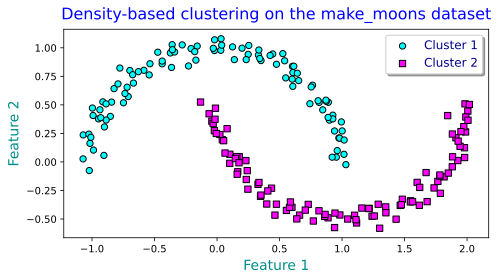

In [15]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)

plt.figure(figsize=(7, 4))
plt.title("Density-based clustering on the make_moons dataset", fontsize=16, color='blue', pad=10)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1], edgecolor='black', marker='o', s=40, color=cmap(0),
            label="Cluster 1")
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1], edgecolor='black', marker='s', s=40, color=cmap(0.999),
            label="Cluster 2")
plt.xlabel("Feature 1", labelpad=5, fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", labelpad=5, fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>DBSCAN algorithm</font> can successfully detect the half-moon shapes, which highlights one of its strengths : <font color='magenta'>clustering data of arbitrary shapes</font>; whereas <font color='#cc33ff'>k-means</font> and <font color='#cc33ff'>agglomerative clustering</font> tend to perform better with <font color='#cc33ff'>spherical or convex-shaped clusters</font>.<br>
    Also, as we have already mentioned, <font color='#cc33ff'>DBSCAN</font> can automatically <font color='magenta'>identify and ignore outliers</font> (<font color='#cc33ff'>noise points</font>) as it does not assign them to any <font color='#cc33ff'>cluster</font>.<br>
    Compared with the <font color='#cc33ff'>k-means algorithm</font>, <font color='#cc33ff'>DBSCAN</font> has the additional advantage of <font color='magenta'>not needing the number of clusters to be specified</font>.<br>
    Compared with <font color='#cc33ff'>agglomerative clustering</font>, <font color='#cc33ff'>DBSCAN</font> is <font color='magenta'>efficient, since it does not need to compute all pairwise distances between the points</font> (eg once we know that a <font color='#cc33ff'>data point</font> has <font color='#1aabff'>$\,p\!-\!1$</font> neighbors we know it is a <font color='#cc33ff'>core point</font>, then once we know it has a neighbor which is another <font color='#cc33ff'>core point</font> we know the connected group it belongs to, we don't need to compute its distance to other <font color='#cc33ff'>core points</font> in the group).<br>$\quad$
        However, we should also note some of <font color='#cc33ff'>DBSCAN</font>'s disadvantages. Its main drawback is that <font color='magenta'>it is highly sensitive to the choice of <font color='#1aabff'>$\epsilon$</font> and <font color='#1aabff'>$p$</font></font> (the radius, and the minimum number of points in a neighborhood to be a core point respectively). Poor choices can result in either over-segmentation or under-segmentation. In particular <font color='#cc33ff'>DBSCAN</font> may <font color='magenta'>struggle with clusters of varying densities</font>, as it uses a single <font color='#1aabff'>$\epsilon$</font> value, which may not be appropriate for all <font color='#1aabff'>clusters</font>.<br>
    Compared with the <font color='#cc33ff'>k-means algorithm</font>, <font color='#cc33ff'>DBSCAN</font> is usually <font color='magenta'>computationally less efficient</font>, especially with large datasets and high-dimensional data.<br>
    Compared with agglomerative clustering, <font color='#cc33ff'>DBSCAN</font> <font color='magenta'>does not produce a hierarchy of clusters</font>, which can be insightful for understanding data at different granularity levels.<br>$\quad$
        All these algorithms suffer from the <font color='#cc33ff'>curse of dimensionality</font> (see part 5, "Dimensionality reduction", "1a. Presentation. The curse of dimensionality"), especially if we use the Euclidean distance. This problem is usually mitigated by using <font color='#cc33ff'>dimensionality reduction techniques</font>, most notably <font color='#cc33ff'>principal component analysis</font> (see part 5, "1. Principal component analysis") and <font color='#cc33ff'>t-SNE</font> (see part 5, "3. Nonlinear dimensionality reduction"). For example, it is particularly common to compress datasets down to two-dimensional subspaces, in order to <font color='#cc33ff'>visualize the clusters</font>. <font color='magenta'>By visualizing the clusters, we can assess whether the clustering algorithm has grouped the data meaningfully and identify potential issues.</font>
